 <h3 align="center">Cyclist - Google Data Analytics</h3>

---







**Estudo de caso 1:** Como um compartilhamento de bicicletas possibilita o sucesso rápido?

**Resumo:** Dados históricos (jan-dez de 2022) da Cyclist, uma empresa fictícia de bicicletas compartilhadas em Chicago, Illinois, Estados Unidos. Com o objetivo de determinar uma estratégia de marketing para converter passageiros casuais em membros anuais com base em dados.

- Passageiros casuais: Clientes que adquirem passes de viagem única ou de dia inteiro;
- Passageiros membros Cyclist: Clientes que adquirem planos anuais.

**Dados:** [DOWNLOAD](https://divvy-tripdata.s3.amazonaws.com/index.html)  | [LICENÇA](https://divvybikes.com/data-license-agreement)

**Por:** [Samuel Neto](https://www.linkedin.com/in/samuel-neto-7b5aa5182/)

**Data de modificação:** 18/11/2023

---



#### PREPARAR

In [ ]:
# Carregando os packages
library(tidyverse)
install.packages("geosphere")
library(geosphere)
install.packages("gridExtra")
library(gridExtra)
install.packages("maps")
library(maps)

In [ ]:
# Carregando os datasets
jan <- read_csv('/content/202201-divvy-tripdata.csv')
fev <- read_csv('/content/202202-divvy-tripdata.csv')
mar <- read_csv('/content/202203-divvy-tripdata.csv')
abr <- read_csv('/content/202204-divvy-tripdata.csv')
maio <- read_csv('/content/202205-divvy-tripdata.csv')
jun <- read_csv('/content/202206-divvy-tripdata.csv')
jul <- read_csv('/content/202207-divvy-tripdata.csv')
ago <- read_csv('/content/202208-divvy-tripdata.csv')
set <- read_csv('/content/202209-divvy-publictripdata.csv')
out <- read_csv('/content/202210-divvy-tripdata.csv')
nov <- read_csv('/content/202211-divvy-tripdata.csv')
dez <- read_csv('/content/202212-divvy-tripdata.csv')

In [38]:
# Verificando se os datasets possuem as mesmas colunas
datasets_list <- list(jan, fev, mar, abr, maio, jun, jul, ago, set, out, nov, dez)
ref_dataset <- names(datasets_list[[1]])

diff_cols <- list()

for (i in 2:length(datasets_list)) {
  actual_dataset <- names(datasets_list[[i]])

  diff_cols[[i - 1]] <- setdiff(ref_dataset, actual_dataset)
}

total_diff <- unlist(diff_cols)

# Verifica se há diferenças
if (length(total_diff) == 0) {
  print("Todos os datasets possuem as mesmas colunas.")
} else {
  print("Há diferenças nas colunas entre os datasets.")
  print("Diferenças encontradas:")
  print(total_diff)
}

[1] "Todos os datasets possuem as mesmas colunas."


In [39]:
# Concatenado todos os dataframes
df_cyclist <- bind_rows(jan, fev, mar, abr, maio, jun, jul, ago, set, out, nov, dez)
# View(df_cyclist)

#### PROCESSAR

In [40]:
# Verificando a estrutura dos dados
str(df_cyclist)
# head(df_cyclist)
# summary(df_cyclist)

spc_tbl_ [5,667,717 × 13] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ride_id           : chr [1:5667717] "C2F7DD78E82EC875" "A6CF8980A652D272" "BD0F91DFF741C66D" "CBB80ED419105406" ...
 $ rideable_type     : chr [1:5667717] "electric_bike" "electric_bike" "classic_bike" "classic_bike" ...
 $ started_at        : POSIXct[1:5667717], format: "2022-01-13 11:59:47" "2022-01-10 08:41:56" ...
 $ ended_at          : POSIXct[1:5667717], format: "2022-01-13 12:02:44" "2022-01-10 08:46:17" ...
 $ start_station_name: chr [1:5667717] "Glenwood Ave & Touhy Ave" "Glenwood Ave & Touhy Ave" "Sheffield Ave & Fullerton Ave" "Clark St & Bryn Mawr Ave" ...
 $ start_station_id  : chr [1:5667717] "525" "525" "TA1306000016" "KA1504000151" ...
 $ end_station_name  : chr [1:5667717] "Clark St & Touhy Ave" "Clark St & Touhy Ave" "Greenview Ave & Fullerton Ave" "Paulina St & Montrose Ave" ...
 $ end_station_id    : chr [1:5667717] "RP-007" "RP-007" "TA1307000001" "TA1309000021" ...
 $ start_lat         : num [1:5

In [41]:
# Tamanho do dataset
print(dim(df_cyclist))

[1] 5667717      13


In [42]:
# Verificando os valores únicos em rideable_type e member_casual
unique_rideable_type <- table(df_cyclist$rideable_type)
unique_member_casual <- table(df_cyclist$member_casual)

# Exibindo o resultado
print(unique_rideable_type)
print(unique_member_casual)


 classic_bike   docked_bike electric_bike 
      2601214        177474       2889029 

 casual  member 
2322032 3345685 


In [43]:
# Transformação dos dados
df_cyclist <- df_cyclist %>%
  mutate(duration = difftime(ended_at, started_at, units = "mins"))  %>%
  mutate(duration = as.numeric(duration))   %>%
  mutate(start_time = strftime(started_at, "%H"))   %>%
  mutate(day_of_week = format(as.Date(started_at), "%A"))  %>%
  mutate(date = format(as.Date(started_at), "%d")) %>%
  mutate(month = format(as.Date(started_at), "%B"))  %>%
  mutate(ride_distance = (distGeo(matrix(c(df_cyclist$start_lng, df_cyclist$start_lat), ncol = 2), matrix(c(df_cyclist$end_lng, df_cyclist$end_lat), ncol = 2)))/1000 )

# View(df_cyclist)

In [44]:
# Verificando se há valores ausentes em todo o dataframe
missing_values <- colSums(is.na(df_cyclist))
# Exibindo o resultado
View(missing_values)

ride_id      rideable_type         started_at           ended_at 
                 0                  0                  0                  0 
start_station_name   start_station_id   end_station_name     end_station_id 
            833064             833064             892742             892742 
         start_lat          start_lng            end_lat            end_lng 
                 0                  0               5858               5858 
     member_casual           duration         start_time        day_of_week 
                 0                  0                  0                  0 
              date              month      ride_distance 
                 0                  0               5858

In [45]:
# Limpeza dos dados
# Duração menor ou igual a zero
# ride_distance com valores ausentes
df_cyclist_clean <- df_cyclist[!(df_cyclist$duration <= 0),]
df_cyclist_clean <- df_cyclist_clean[!is.na(df_cyclist_clean[, "ride_distance"]), ]

In [46]:
# Verificando se há valores ausentes em todo o dataframe
missing_values <- colSums(is.na(df_cyclist_clean))
# Exibindo o resultado
View(missing_values)

ride_id      rideable_type         started_at           ended_at 
                 0                  0                  0                  0 
start_station_name   start_station_id   end_station_name     end_station_id 
            833038             833038             886678             886678 
         start_lat          start_lng            end_lat            end_lng 
                 0                  0                  0                  0 
     member_casual           duration         start_time        day_of_week 
                 0                  0                  0                  0 
              date              month      ride_distance 
                 0                  0                  0

In [47]:
# Tamanho do dataset final
print(dim(df_cyclist_clean))

[1] 5661328      19


In [48]:
#View(df_cyclist_clean)

In [49]:
# df_cyclist_save <- df_cyclist_clean[, c("rideable_type", "member_casual", "duration", "start_time", "day_of_week", "date", "month", "ride_distance", "start_station_name", "start_lat", "start_lng")]
# write.csv(df_cyclist_save, file = '/content/df_cyclist.csv', row.names = FALSE)

#### ANALISAR

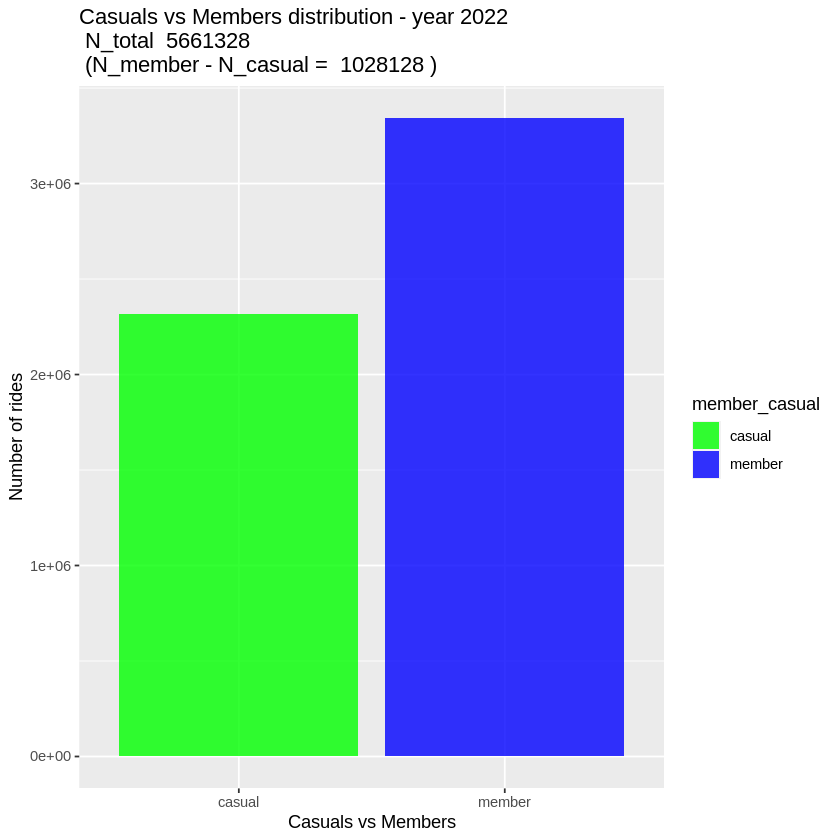

In [50]:
# Verificando o número de viagens por tipo de usuário
unique_member_casual <- table(df_cyclist_clean$member_casual)
total_users <- unique_member_casual["member"] + unique_member_casual["casual"]
diff_users <- unique_member_casual["member"] - unique_member_casual["casual"]

ggplot(df_cyclist_clean, aes(x = member_casual, fill=member_casual, alpha = member_casual)) +
    geom_bar() +
    scale_fill_manual(values = c("green", "blue")) +
    scale_alpha_manual(values = c(0.8, 0.8)) +
    labs(x="Casuals vs Members", y="Number of rides", title= paste(
    "Casuals vs Members distribution - year 2022", "\n",
    "N_total ", total_users, "\n", "(N_member - N_casual = ", diff_users, ")"))

**Insight:** É claramente visível que o número de viagens por usuários do tipo membro Cyclist foi maior do que do tipo casual para o ano de 2022. Onde, 59,08% do total de viagens foram realizadas por usuários membros Cyclist e 40,92% do tipo casual.

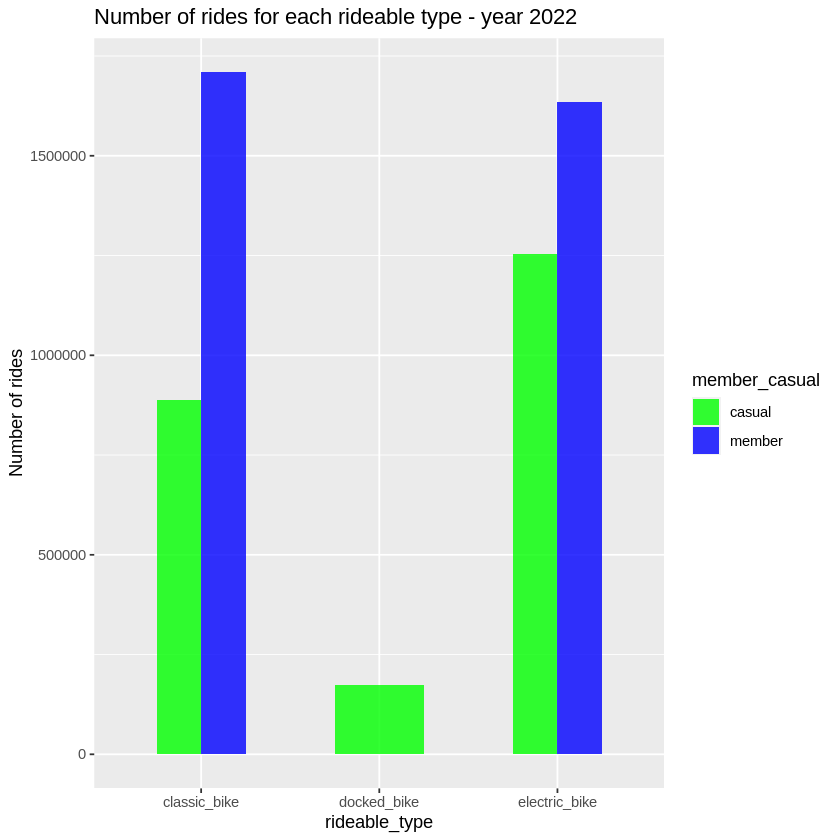

In [51]:
# Verificando o número de viagens por tipo de bicicleta
df_rideable_type <- df_cyclist_clean

df_rideable_type %>%
  group_by(member_casual, rideable_type) %>%
  summarise(number_of_rides = n(), .groups="drop") %>%
  arrange(member_casual, rideable_type)  %>%
  ggplot(aes(x = rideable_type, y = number_of_rides, fill = member_casual, alpha = member_casual)) +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  labs(y="Number of rides", title ="Number of rides for each rideable type - year 2022") +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

**Insight:**
- Somente passageiros casuais utilizam a docked_bike;
- Passageiros membros Cyclist utilizam mais a classic_bike do que a eletric_bike

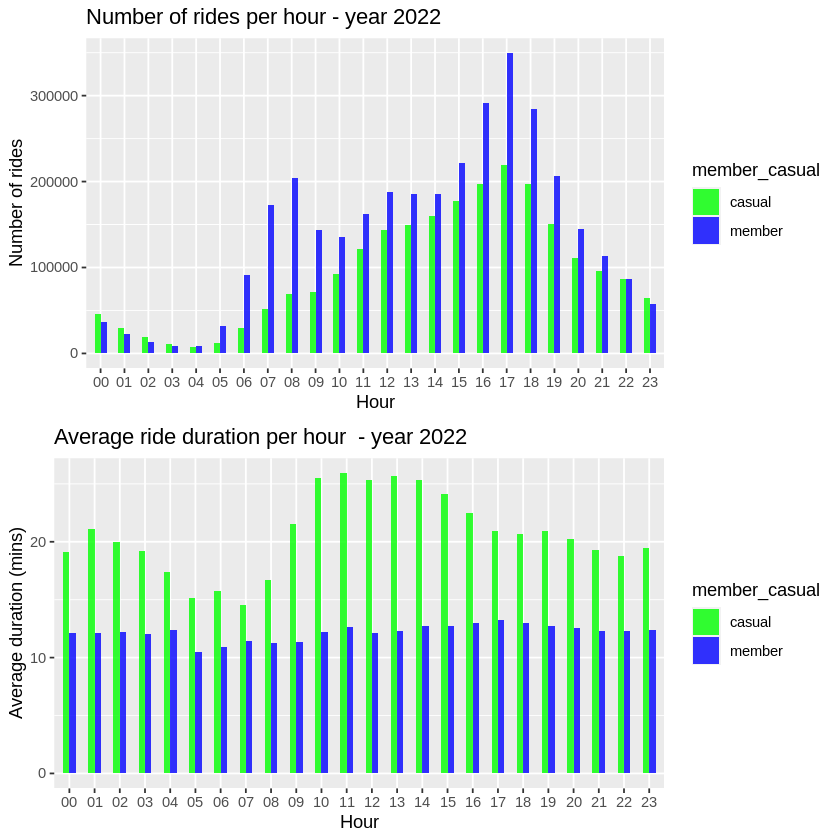

In [52]:
# Verificando o número de viagens por hora do dia
rides_per_hour <- df_cyclist_clean

rides_per_hour$start_time <- ordered(rides_per_hour$start_time,
                                    levels=c("00", "01", "02", "03", "04", "05", "06","07", "08", "09", "10", "11", "12",
                                    "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"))

# Verificando o número de viagens por hora do dia
plot_1 <- rides_per_hour %>%
  group_by(member_casual, start_time) %>%
  summarise(number_of_rides = n(), .groups="drop") %>%
  arrange(member_casual, start_time)  %>%
  ggplot(aes(x = start_time, y = number_of_rides, fill = member_casual, alpha = member_casual)) +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  labs(y="Number of rides", x = "Hour",title ="Number of rides per hour - year 2022") +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

# Verificando a duração média das viagens por hora do dia
plot_2 <- rides_per_hour %>%
  group_by(member_casual, start_time) %>%
  summarise(average_ride_duration = mean(duration), .groups="drop") %>%
  arrange(member_casual, start_time) %>%
  ggplot(aes(x = start_time, y = average_ride_duration, fill = member_casual, alpha = member_casual)) +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  labs(y="Average duration (mins)", x = "Hour", title ="Average ride duration per hour  - year 2022") +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

grid.arrange(plot_1, plot_2, ncol = 1, heights = c(5,5))


**Insight:**

**(Gráfico 1)**
- Membros Cyclist começam a utilizar o serviço com maior frequência a partir das 6h e com picos maiores entre 16-18h, já os usuários casuais apresentam um aumento gradativo das 6-17h;
- Menor número de viagens para ambos os tipos de passageiros é de 2-4h;

**(Gráfico 2)**
- Passageiros do tipo casual tem uma duração média maior em relação aos cyclist;
- Passageiros membros Cyclist possuem uma duração média próxima durante todos os horários;
- A duração dos passageiros casuais é maior durante as 9-14h.

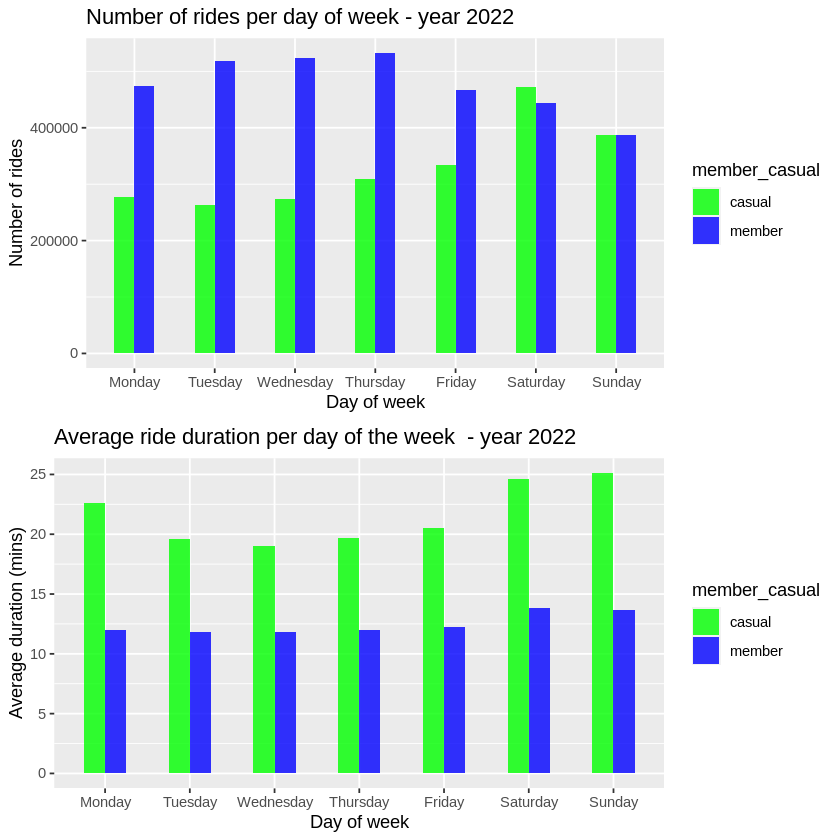

In [53]:
# Reordenando os dias da semana
rides_per_day_of_week <- df_cyclist_clean

rides_per_day_of_week$day_of_week <- ordered(rides_per_day_of_week$day_of_week,
                                    levels=c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

# Verificando o número de viagens por dia da semana
plot_1 <- rides_per_day_of_week %>%
  group_by(member_casual, day_of_week) %>%
  summarise(number_of_rides = n(), .groups="drop") %>%
  arrange(member_casual, day_of_week)  %>%
  ggplot(aes(x = day_of_week, y = number_of_rides, fill = member_casual, alpha = member_casual)) +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  labs(y="Number of rides", x = "Day of week",title ="Number of rides per day of week - year 2022") +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

# Verificando a duração média das viagens por dia da semana
plot_2 <- rides_per_day_of_week %>%
  group_by(member_casual, day_of_week) %>%
  summarise(average_ride_duration = mean(duration), .groups="drop") %>%
  arrange(member_casual, day_of_week) %>%
  ggplot(aes(x = day_of_week, y = average_ride_duration, fill = member_casual, alpha = member_casual)) +
  labs(y="Average duration (mins)", x = "Day of week", title ="Average ride duration per day of the week  - year 2022") +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

grid.arrange(plot_1, plot_2, ncol = 1, heights = c(5,5))


**Insight:**

**(Gráfico 1)**
- Membros Cyclist utilizam mais os serviços durante os dias da semana em relação aos passageiros casuais. Já o número de viagens pelos passageiros casuais é maior somente nos finais de semana (sábado e domingo);
- Também é possível notar um aumento gradativo no número de viagens para os passageiros casuais durante os dias da semana para o final de semana.

**(Gráfico 2)**
- Passageiros do tipo casual tem uma duração média maior em relação aos membros Cyclist;
- Passageiros membros Cyclist possuem uma duração média próxima durante todos os dias;
- A duração dos passageiros casuais é maior durante os finais de semana.


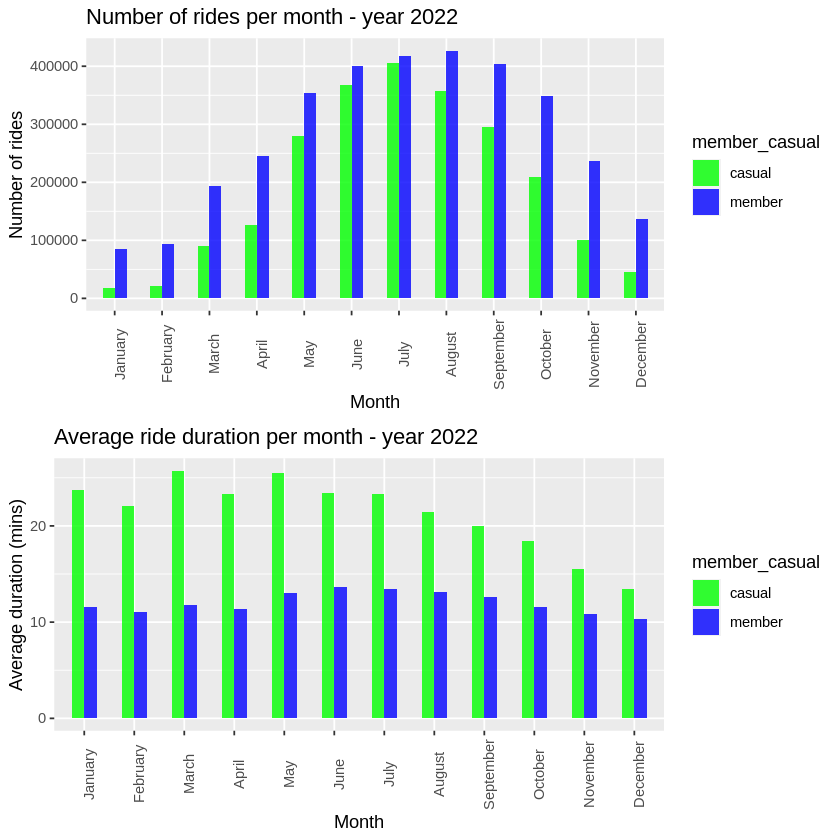

In [54]:
# Verificando a distribuição do número de viagens por mês
rides_per_month<- df_cyclist_clean

rides_per_month$month <- ordered(rides_per_month$month,
                                    levels=c("January", "February", "March", "April", "May", "June", "July",
                                    "August", "September", "October", "November", "December"))

# Verificando o número de viagens por mês
plot_1 <- rides_per_month %>%
  group_by(member_casual, month) %>%
  summarise(number_of_rides = n(), .groups="drop") %>%
  arrange(member_casual, month)  %>%
  ggplot(aes(x = month, y = number_of_rides, fill = member_casual, alpha = member_casual)) +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  labs(y="Number of rides", x = "Month",title ="Number of rides per month - year 2022") +
  theme(axis.text.x = element_text(angle = 90)) +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

# Verificando a duração média das viagens por mês
plot_2 <- rides_per_month %>%
  group_by(member_casual, month) %>%
  summarise(average_ride_duration = mean(duration), .groups="drop") %>%
  arrange(member_casual, month)  %>%
  ggplot(aes(x = month, y = average_ride_duration, fill = member_casual, alpha = member_casual)) +
  scale_fill_manual(values = c("green", "blue")) +
  scale_alpha_manual(values = c(0.8, 0.8)) +
  labs(y="Average duration (mins)", x = "Month", title ="Average ride duration per month - year 2022") +
  theme(axis.text.x = element_text(angle = 90)) +
  geom_col(width=0.5, position = position_dodge(width=0.5)) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE))

grid.arrange(plot_1, plot_2, ncol = 1, heights = c(5,5))

**Insight:**

**(Gráfico 1)**
- Membros Cyclist utilizam mais os serviços durante todos os meses do ano  em relação aos passageiros casuais.
- Ambos os tipos de passageiros apresentam a distribuição parecida no número de viagens;
- Todos os tipos de passageiros utilizam com maior frequência o serviço da cyclist durante a estação do verão (junho, julho e agosto).

**(Gráfico 2)**
- Passageiros do tipo casual tem uma duração média maior em relação aos membros cyclist;
- Passageiros membros Cyclist possuem uma duração média próxima durante todos os meses;
- A duração dos passageiros casuais diminui durante os meses de setembro a dezembro.

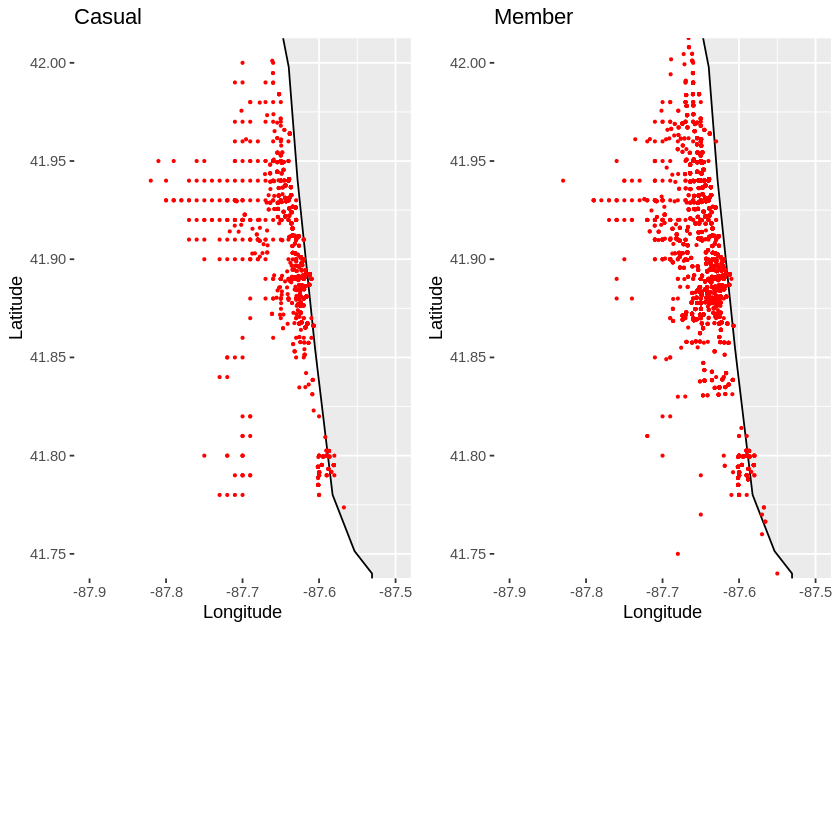

In [55]:
# Verificando pela localização
df_location <- df_cyclist_clean %>%
    group_by(start_lng, start_lat, end_lng, end_lat, member_casual, rideable_type) %>%
    summarise(total_rides = n(),.groups="drop") %>%
    filter(total_rides > 100)

casual <- df_location %>% filter(member_casual == "casual")
member <- df_location %>% filter(member_casual == "member")

# Filtrando apenas para a área de Chicago (Illinois)
chicago <- subset(map_data("state"), region %in% c("illinois", "chicago"))

map_zoom_chicago <- ggplot() +
  geom_polygon(data = chicago, aes(x = long, y = lat, group = group),
               fill = "white", color = "black") +
  coord_cartesian(xlim = c(-87.9, -87.5), ylim = c(41.75, 42)) +
  labs(title = "Chicago",
       x = "Longitude",
       y = "Latitude")

plot_1 <- map_zoom_chicago +
  geom_point(data = casual, aes(x = start_lng, y = start_lat), color = "red", size = 0.5)+
    labs(title = "Casual")

plot_2 <- map_zoom_chicago +
  geom_point(data = member, aes(x = start_lng, y = start_lat), color = "red", size = 0.5)+
    labs(title = "Member")

grid.arrange(plot_1, plot_2, ncol = 2, heights = c(6,2))

**Insight:**
- Cyclist utilizam o serviço em diversas regiões de Chicago, enquando os passageiros casuais se concentram mais na região central.


#### AGIR

**Considerações finais:**
- Maior número de viagens foram realizadas por  membros Cyclist em relação a quantidade de viagens dos passageiros casuais;
- A duração das viagens é maior para os passageiros casuais;
- Os passageiros casuais ultrapassam o número de viagens durante os finais de semana em realção aos membros Cyclist;
- O pico da utilização dos serviços da Cyclist é no período do final de tarde;
- Para ambos os tipos de passageiros, o período com maior número de viagens ocorre nos períodos mais quentes nas estações de verão e outono.

**Análises futuras (dependentes de outros dados):**
- Faixa etária dos passageiros;
- Gênero;
- Identificação do passageiro por meio de ID, desta maneira seria possível verificar a recorrência da utilização do serviço da Cyclist;
- Detalhes sobre o preço por tipo de passageiro e tipo de bicicleta.

**Recomendações:**

Apesar da maioria das viagens serem feitas por membros anuais da Cyclist, outras estratégias poderiam ser adotadas para o aumento da receita e fidelização dos clientes, como:
- Introdução de planos por estação do ano, visto que existem um aumento dos passageiros casuais durante as estações do verão e outono;
- Primeiro mês grátis no plano anual;
- Cupons de desconto por tipo de plano ou tipo de veículo;
- Incentivos pela recorrência da utilização da Cyclist;
- Campanhas voltadas ao benefícios sociais e ambientais pela utilização do serviço da Cyclist.
